In [6]:
from itertools import combinations, groupby

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import seaborn as sns
from scipy import spatial
import warnings

from pymutspec.draw import plot_mutspec192, plot_mutspec12

In [7]:
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

### Df with numbers of codon rel

In [8]:
category_anticodon = pd.read_table('../data/external/Anticidon_mtDNA_class.txt', sep='\t')
category_anticodon = category_anticodon.drop(['Anticodon', 'AA'], axis=1)
category_anticodon.head()

,Codon,Type
0,TTT,1
1,TTC,0
2,TCT,0
3,TCC,3
4,TCA,2


### tRNA anticodon

In [9]:
tRNA_anticodon = pd.read_table('../data/external/reference_tRNA_anticodons-wStop.tsv')
tRNA_anticodon = tRNA_anticodon[tRNA_anticodon['AA.abr'] != 'Stop']
tRNA_anticodon = tRNA_anticodon.loc[:,['Codon.dna', 'AA.matchbool']]
tRNA_anticodon = tRNA_anticodon.rename(columns={'Codon.dna': 'Codon', 'AA.matchbool': 'Type'})
tRNA_anticodon.head()

,Codon,Type
0,TTT,near
1,TTC,*
2,TTA,*
3,TTG,near
4,CTT,near


### Observed mutations

In [10]:
observed = pd.read_table('../data/VertebratePolymorphisms.MutSpecDataWithNonSyn.txt', sep=' ')
observed = observed.drop(['AncestralSeqName', 'DescendantSeqName', 'Branch', 'CodonPosition'], axis=1)
observed = observed[(observed.Gene == 'CytB')]
observed = observed[(observed.MutType == 'FourFold') | (observed.MutType == 'Syn')]
observed.head()

,Species,Gene,PreviousAncCodon,AncestorCodon,NextAncCodon,PreviousDesCodon,DescendantCodon,NextDesCodon,AncestralAA,DescendantAA,Subs,MutType,A,T,G,C
1,Abbottina_obtusirostris,CytB,ACA,TCA,CTA,ACA,TCG,CTA,S,S,A_G,FourFold,504,172,97,248
2,Abbottina_obtusirostris,CytB,CCT,GCT,AAC,CCT,GCC,AAC,A,A,T_C,FourFold,504,172,97,248
3,Abbottina_obtusirostris,CytB,CCA,TGG,GGG,CCA,TGA,GGG,W,W,G_A,Syn,504,172,97,248
4,Abbottina_obtusirostris,CytB,GGC,TTA,AAC,GGC,CTA,AAC,L,L,T_C,Syn,504,172,97,248
5,Abbottina_obtusirostris,CytB,CTT,CAT,GCC,CTT,CAC,GCC,H,H,T_C,Syn,504,172,97,248


Merge observed df with anticodon rel and num

In [11]:
obs_anticodon = observed.merge(tRNA_anticodon, left_on='AncestorCodon', right_on='Codon', 
                               how='left').drop('Codon', axis=1).rename(columns={'Type':'AncestorAnti'})
obs_anticodon = obs_anticodon.merge(tRNA_anticodon, left_on='DescendantCodon', right_on='Codon', 
                               how='left').drop('Codon', axis=1).rename(columns={'Type':'DescendantAnti'})
obs_anticodon = obs_anticodon.merge(category_anticodon, left_on='AncestorCodon', right_on='Codon', 
                               how='left').drop('Codon', axis=1).rename(columns={'Type':'AncestorNumAnti'})
obs_anticodon = obs_anticodon.merge(category_anticodon, left_on='DescendantCodon', right_on='Codon', 
                               how='left').drop('Codon', axis=1).rename(columns={'Type':'DescendNumAnti'})
obs_anticodon.head()

,Species,Gene,PreviousAncCodon,AncestorCodon,NextAncCodon,PreviousDesCodon,DescendantCodon,NextDesCodon,AncestralAA,DescendantAA,Subs,MutType,A,T,G,C,AncestorAnti,DescendantAnti,AncestorNumAnti,DescendNumAnti
0,Abbottina_obtusirostris,CytB,ACA,TCA,CTA,ACA,TCG,CTA,S,S,A_G,FourFold,504,172,97,248,*,near,2,1
1,Abbottina_obtusirostris,CytB,CCT,GCT,AAC,CCT,GCC,AAC,A,A,T_C,FourFold,504,172,97,248,near,near,0,3
2,Abbottina_obtusirostris,CytB,CCA,TGG,GGG,CCA,TGA,GGG,W,W,G_A,Syn,504,172,97,248,near,*,1,0
3,Abbottina_obtusirostris,CytB,GGC,TTA,AAC,GGC,CTA,AAC,L,L,T_C,Syn,504,172,97,248,*,*,0,2
4,Abbottina_obtusirostris,CytB,GGC,TTA,AAC,GGC,CTA,AAC,L,L,T_C,Syn,504,172,97,248,*,*,0,1


Functiouns to extract subsitutions either from obs and exp

In [12]:
def define_type_anti(ancestral, descendant):
    if ancestral == '*' and descendant == '*':
        return ('WCF-WCF')
    elif ancestral == '*' and descendant == 'near':
        return ('WCF-Wooble')
    elif ancestral == 'near' and descendant == 'near':
        return ('Wooble-Wooble')
    elif ancestral == 'near' and descendant == '*':
        return ('Wooble-WCF')

def numerical_anti_rel(ancestral, descendant):
    return str(ancestral) + '-' + str(descendant)
    
def get_sub_pos(ancestral, descendant):
    '''Get position of substitution between Ancestor and Descendant codons.
    Args:
        seq1: Ancestral codon
        seq2: Descendant codon
    Returns:
        Number of position 
    '''
    for nuc_num in range(len(ancestral)):
        if ancestral[nuc_num] != descendant[nuc_num]:
            return nuc_num


def get_mutated_codon(codon, mutation, pos_of_mut):

    changed_nucleotide = mutation[4]
    if pos_of_mut == 0:
        return changed_nucleotide + codon[1] + codon[2]
    elif pos_of_mut == 1:
        return codon[0] + changed_nucleotide + codon[2]
    elif pos_of_mut == 2:
        return codon[0] + codon[1] + changed_nucleotide


def get_sub(ancestral, descendant):
    '''Get substitution between Ancestor and Descendant codons.
    Args:
        seq1: Ancestral codon
        seq2: Descendant codon
    Returns:
        Codon with substitution in format: A[A>T]C
    '''
    pos = get_sub_pos(ancestral, descendant)
    if pos == 0:
        return '[' + ancestral[0] + '>' + descendant[0] + ']' + ancestral[1] + ancestral[2]
    elif pos == 1:
        return ancestral[0] + '[' + ancestral[1] + '>' + descendant[1] + ']' + ancestral[2]
    elif pos == 2:
        return ancestral[0] +  ancestral[1] + '[' + ancestral[2] + '>'+ descendant[2] + ']'
    

def get_comp(row: pd.Series):
    ''' Get 3 and 5 components mutational spectrum from table
    Args:
        row - contains Ancestor and  Descendant codons
    Returns:
        out - pd.DataFrame with 3 and 5 component mutspec
    '''
    prev_anc_codon = row['PreviousAncCodon']
    anc_codon = row['AncestorCodon']
    next_anc_codon = row['NextAncCodon']
    des_codon = row['DescendantCodon']

    # Get position of substitution
    pos = get_sub_pos(anc_codon, des_codon)

    # Add subs 
    codon_with_sub = get_sub(anc_codon, des_codon)

    # Extract
    complete = list(prev_anc_codon + codon_with_sub + next_anc_codon)
    pos_in_complete = 3 + pos
    mut3 = complete[pos_in_complete - 1:pos_in_complete + 6]
    mut5 = complete[pos_in_complete - 2:pos_in_complete + 7]

    # Check if component is full (without - and ?)
    if '-' not in mut3 and '-' not in mut5 and '?' not in mut3 and '?' not in mut5:
        out = pd.DataFrame({'Species': row['Species'], 'Gene': row['Gene'], 'Codon' : row['AncestorCodon'],
                            'MutType': [row['TypeOfSubs']], '3Pos': row['3Pos'], 
                            'Mut3': ''.join(mut3), 'Mut5': ''.join(mut5), 'Pos': pos + 1, 'TypeOfAnti': row['TypeOfAnti'], 'NumAnti': row['NumAnti']})
        return out
    

### Get observed df to 192 component format with context and subs info

In [13]:
obs_anticodon['TypeOfAnti'] = obs_anticodon.apply(lambda x : define_type_anti(x.AncestorAnti, x.DescendantAnti), axis=1)
obs_anticodon['TypeOfSubs'] = obs_anticodon['MutType'].apply(lambda x: 0 if x == 'NSyn' else(1 if x == 'Syn'  else 2))
obs_anticodon['3Pos'] = obs_anticodon.apply(lambda x: 1 if get_sub_pos(x.AncestorCodon, x.DescendantCodon) == 2 else 0, axis=1) 
obs_anticodon['NumAnti'] = obs_anticodon.apply(lambda x: numerical_anti_rel(x.AncestorNumAnti, x.DescendNumAnti), axis=1)
obs_anticodon.head()

,Species,Gene,PreviousAncCodon,AncestorCodon,NextAncCodon,PreviousDesCodon,DescendantCodon,NextDesCodon,AncestralAA,DescendantAA,...,G,C,AncestorAnti,DescendantAnti,AncestorNumAnti,DescendNumAnti,TypeOfAnti,TypeOfSubs,3Pos,NumAnti
0,Abbottina_obtusirostris,CytB,ACA,TCA,CTA,ACA,TCG,CTA,S,S,...,97,248,*,near,2,1,WCF-Wooble,2,1,2-1
1,Abbottina_obtusirostris,CytB,CCT,GCT,AAC,CCT,GCC,AAC,A,A,...,97,248,near,near,0,3,Wooble-Wooble,2,1,0-3
2,Abbottina_obtusirostris,CytB,CCA,TGG,GGG,CCA,TGA,GGG,W,W,...,97,248,near,*,1,0,Wooble-WCF,1,1,1-0
3,Abbottina_obtusirostris,CytB,GGC,TTA,AAC,GGC,CTA,AAC,L,L,...,97,248,*,*,0,2,WCF-WCF,1,0,0-2
4,Abbottina_obtusirostris,CytB,GGC,TTA,AAC,GGC,CTA,AAC,L,L,...,97,248,*,*,0,1,WCF-WCF,1,0,0-1


In [14]:
final_obs = pd.concat(obs_anticodon.apply(lambda x: get_comp(x), axis=1).values)
final_obs.head()

,Species,Gene,Codon,MutType,3Pos,Mut3,Mut5,Pos,TypeOfAnti,NumAnti
0,Abbottina_obtusirostris,CytB,TCA,2,1,C[A>G]C,TC[A>G]CT,3,WCF-Wooble,2-1
0,Abbottina_obtusirostris,CytB,GCT,2,1,C[T>C]A,GC[T>C]AA,3,Wooble-Wooble,0-3
0,Abbottina_obtusirostris,CytB,TGG,1,1,G[G>A]G,TG[G>A]GG,3,Wooble-WCF,1-0
0,Abbottina_obtusirostris,CytB,TTA,1,0,C[T>C]T,GC[T>C]TA,1,WCF-WCF,0-2
0,Abbottina_obtusirostris,CytB,TTA,1,0,C[T>C]T,GC[T>C]TA,1,WCF-WCF,0-1


# Expected mutations df

In [15]:
expected = pd.read_csv('../data/exp_mut_spec.csv', sep='\t')
expected = expected[(expected.Gene == 'CYTB') & (expected.MutType >= 1)]
expected['TransformedCodon'] = expected.apply(lambda x: get_mutated_codon(x.Codon, x.Mut3, x.Pos), axis=1)
expected.head()

,Species,Gene,Mut3,MutType,Pos,3Pos,Codon,TransformedCodon
3,Rhinopithecus_bieti,CYTB,T[G>A]A,1,2,1,ATG,ATA
12,Rhinopithecus_bieti,CYTB,C[C>A]C,2,2,1,ACC,ACA
13,Rhinopithecus_bieti,CYTB,C[C>T]C,2,2,1,ACC,ACT
14,Rhinopithecus_bieti,CYTB,C[C>G]C,2,2,1,ACC,ACG
21,Rhinopithecus_bieti,CYTB,C[T>A]A,2,2,1,CCT,CCA


### Same merge but wth expected substitutions

In [16]:
exp_anticodon = expected.merge(tRNA_anticodon, left_on='Codon', right_on='Codon', 
                               how='left').rename(columns={'Type':'AncestorAnti'})
exp_anticodon = exp_anticodon.merge(tRNA_anticodon, left_on='TransformedCodon', 
                              right_on='Codon', how='left').drop('Codon_y', axis=1).rename(columns={'Type':'DescendantAnti', 'Codon_x': 'Codon'})
exp_anticodon = exp_anticodon.merge(category_anticodon, left_on='Codon', right_on='Codon', 
                               how='left').drop('Codon', axis=1).rename(columns={'Type':'AncestorNumAnti'})
exp_anticodon = exp_anticodon.merge(category_anticodon, left_on='TransformedCodon', right_on='Codon', 
                               how='left').drop('Codon', axis=1).rename(columns={'Type':'DescendNumAnti'})

exp_anticodon['TypeOfAnti'] = exp_anticodon.apply(lambda x : define_type_anti(x.AncestorAnti, x.DescendantAnti), axis=1)
exp_anticodon['NumAnti'] = exp_anticodon.apply(lambda x: numerical_anti_rel(x.AncestorNumAnti, x.DescendNumAnti), axis=1)
final_exp = exp_anticodon.drop(['AncestorAnti', 'DescendantAnti', 'AncestorNumAnti', 'DescendNumAnti','TransformedCodon'], axis=1)
final_exp.head()

,Species,Gene,Mut3,MutType,Pos,3Pos,TypeOfAnti,NumAnti
0,Rhinopithecus_bieti,CYTB,T[G>A]A,1,2,1,WCF-Wooble,0-1
1,Rhinopithecus_bieti,CYTB,C[C>A]C,2,2,1,Wooble-WCF,3-2
2,Rhinopithecus_bieti,CYTB,C[C>T]C,2,2,1,Wooble-Wooble,3-0
3,Rhinopithecus_bieti,CYTB,C[C>G]C,2,2,1,Wooble-Wooble,3-1
4,Rhinopithecus_bieti,CYTB,C[T>A]A,2,2,1,Wooble-WCF,0-2


### How many species in each df

In [17]:
sps_exp = final_exp['Species']
sps_obs = final_obs['Species']
print(len(sps_exp.unique()), len(sps_obs.unique()), sep=', ')


1312, 1562


In [18]:
final_obs = final_obs.loc[final_obs['Species'].isin(sps_exp.unique())]
sps_obs = final_obs['Species']
final_exp = final_exp.loc[final_exp['Species'].isin(sps_obs.unique())]
final_obs = final_obs.reset_index().drop(['index'], axis=1)

### Check that number of species in both df are the same

In [19]:
sps_exp = final_exp['Species']
sps_obs = final_obs['Species']
print(len(sps_exp.unique()), len(sps_obs.unique()), sep=', ')

1024, 1024


### HAPPENS ONLY IN WOOBLE-WCF ANTICODON CONDITIONS

In [20]:
final_obs[(final_obs.Mut3 == 'G[G>A]G')].Codon.unique() 

array(['TGG', 'GGG', 'CGG'], dtype=object)

In [21]:
# cC>Tc mutation appears only in 3d position
final_obs[(final_obs.Mut3 == 'G[G>A]G')].Codon.unique() # how many codons represented by mutation c[C>T]c

array(['TGG', 'GGG', 'CGG'], dtype=object)

In [22]:
for cond_anti in list(final_obs.TypeOfAnti.unique()):
    exp_check = final_exp[final_exp.TypeOfAnti == cond_anti]
    obs_check = final_obs[final_obs.TypeOfAnti == cond_anti]

    print(f'Anticodon condition - {cond_anti} and expected df presented by 192 comp is {len(exp_check.Mut3.unique())} , 12 comp is {len(exp_check.Mut3.str.slice(2, 5).unique())};'
          f'observed df presented by {len(obs_check.Mut3.unique())} ; 12 comp is {len(obs_check.Mut3.str.slice(2, 5).unique())}')

Anticodon condition - WCF-Wooble and expected df presented by 192 comp is 56 , 12 comp is 5;observed df presented by 56 ; 12 comp is 5
Anticodon condition - Wooble-Wooble and expected df presented by 192 comp is 74 , 12 comp is 6;observed df presented by 107 ; 12 comp is 12
Anticodon condition - Wooble-WCF and expected df presented by 192 comp is 56 , 12 comp is 5;observed df presented by 56 ; 12 comp is 5
Anticodon condition - WCF-WCF and expected df presented by 192 comp is 8 , 12 comp is 2;observed df presented by 80 ; 12 comp is 12


In [23]:
for cond_anti_num in list(final_obs.NumAnti.unique()):
    exp_check = final_exp[final_exp.NumAnti == cond_anti_num]
    obs_check = final_obs[final_obs.NumAnti == cond_anti_num]

    print(f'Anticodon condition - {cond_anti_num} and expected df presented by 192 comp is {len(exp_check.Mut3.unique())} , 12 comp is {len(exp_check.Mut3.str.slice(2, 5).unique())};'
          f'observed df presented by {len(obs_check.Mut3.unique())} ; 12 comp is {len(obs_check.Mut3.str.slice(2, 5).unique())}')

Anticodon condition - 2-1 and expected df presented by 192 comp is 12 , 12 comp is 1;observed df presented by 18 ; 12 comp is 4
Anticodon condition - 0-3 and expected df presented by 192 comp is 12 , 12 comp is 1;observed df presented by 12 ; 12 comp is 1
Anticodon condition - 1-0 and expected df presented by 192 comp is 48 , 12 comp is 6;observed df presented by 48 ; 12 comp is 6
Anticodon condition - 0-2 and expected df presented by 192 comp is 16 , 12 comp is 2;observed df presented by 16 ; 12 comp is 2
Anticodon condition - 0-1 and expected df presented by 192 comp is 48 , 12 comp is 6;observed df presented by 48 ; 12 comp is 6
Anticodon condition - 0-0 and expected df presented by 192 comp is 8 , 12 comp is 2;observed df presented by 66 ; 12 comp is 12
Anticodon condition - 3-0 and expected df presented by 192 comp is 12 , 12 comp is 1;observed df presented by 12 ; 12 comp is 1
Anticodon condition - 3-2 and expected df presented by 192 comp is 12 , 12 comp is 1;observed df present

### Make function to calculate mutdpec for both types of the Anticodon combinations

In [24]:
### Additional function to translate triplets
def getrevers(mut):
    translator = str.maketrans("ACGT", "TGCA")
    new_mut = mut[-1] + mut[1:-1] + mut[0]
    new_mut = new_mut.translate(translator)
    return new_mut

In [25]:
def calculate_mutspec(observed, expected,  type_of_anti_mut, is_it_num = False):

# Filter by anticodon relationships
    
    if is_it_num is False:
        if type_of_anti_mut != 'all':
            observed = observed[observed.TypeOfAnti == type_of_anti_mut]
            expected = expected[expected.TypeOfAnti == type_of_anti_mut]

    elif is_it_num is True:
        if type_of_anti_mut != 'all':
            observed = observed[observed.NumAnti == type_of_anti_mut]
            expected = expected[expected.NumAnti == type_of_anti_mut]
        else:
            ValueError('Input correct anticodon num')

    if observed.shape[0] == 0 or expected.shape[0] == 0:
        pass

    else:
    # Count codon freq for observed df
        count_obs_df = observed.groupby(['Species', 'Gene']).Mut3.value_counts()
        count_obs_df.name = 'CountMut3'
        count_obs_df = count_obs_df.reset_index()
        oberved_cnt = count_obs_df.pivot(index=['Species', 'Gene'], columns='Mut3', values='CountMut3').fillna(0)
        oberved_cnt['ExpectedObserved'] = 'Observed'

    # Count codon freq for expected df
        count_exp_df = expected.groupby(['Species', 'Gene']).Mut3.value_counts()
        count_exp_df.name = 'CountMut3'
        count_exp_df = count_exp_df.reset_index()
        expected_cnt = count_exp_df.pivot(index=['Species', 'Gene'], columns='Mut3', values='CountMut3').fillna(0)
        expected_cnt['ExpectedObserved'] = 'Expected'

    # Merge observed and expected 
        final_df = pd.concat([expected_cnt, oberved_cnt])
        final_df = final_df.sort_values(['Species'])
        final_df.insert(0, 'ExpectedObserved', final_df.pop('ExpectedObserved'))
        final_df = final_df.fillna(0)
        final_df = final_df.reset_index()

    # Add 0 to not presented mutations for species

        possible_sbs192 = [
            "A[A>C]A", "A[A>C]C", "A[A>C]G", "A[A>C]T", "C[A>C]A", "C[A>C]C", "C[A>C]G", "C[A>C]T", 
            "G[A>C]A", "G[A>C]C", "G[A>C]G", "G[A>C]T", "T[A>C]A", "T[A>C]C", "T[A>C]G", "T[A>C]T", 
            "A[A>G]A", "A[A>G]C", "A[A>G]G", "A[A>G]T", "C[A>G]A", "C[A>G]C", "C[A>G]G", "C[A>G]T", 
            "G[A>G]A", "G[A>G]C", "G[A>G]G", "G[A>G]T", "T[A>G]A", "T[A>G]C", "T[A>G]G", "T[A>G]T", 
            "A[A>T]A", "A[A>T]C", "A[A>T]G", "A[A>T]T", "C[A>T]A", "C[A>T]C", "C[A>T]G", "C[A>T]T", 
            "G[A>T]A", "G[A>T]C", "G[A>T]G", "G[A>T]T", "T[A>T]A", "T[A>T]C", "T[A>T]G", "T[A>T]T", 
            "A[C>A]A", "A[C>A]C", "A[C>A]G", "A[C>A]T", "C[C>A]A", "C[C>A]C", "C[C>A]G", "C[C>A]T", 
            "G[C>A]A", "G[C>A]C", "G[C>A]G", "G[C>A]T", "T[C>A]A", "T[C>A]C", "T[C>A]G", "T[C>A]T", 
            "A[C>G]A", "A[C>G]C", "A[C>G]G", "A[C>G]T", "C[C>G]A", "C[C>G]C", "C[C>G]G", "C[C>G]T", 
            "G[C>G]A", "G[C>G]C", "G[C>G]G", "G[C>G]T", "T[C>G]A", "T[C>G]C", "T[C>G]G", "T[C>G]T", 
            "A[C>T]A", "A[C>T]C", "A[C>T]G", "A[C>T]T", "C[C>T]A", "C[C>T]C", "C[C>T]G", "C[C>T]T", 
            "G[C>T]A", "G[C>T]C", "G[C>T]G", "G[C>T]T", "T[C>T]A", "T[C>T]C", "T[C>T]G", "T[C>T]T", 
            "A[G>A]A", "A[G>A]C", "A[G>A]G", "A[G>A]T", "C[G>A]A", "C[G>A]C", "C[G>A]G", "C[G>A]T", 
            "G[G>A]A", "G[G>A]C", "G[G>A]G", "G[G>A]T", "T[G>A]A", "T[G>A]C", "T[G>A]G", "T[G>A]T", 
            "A[G>C]A", "A[G>C]C", "A[G>C]G", "A[G>C]T", "C[G>C]A", "C[G>C]C", "C[G>C]G", "C[G>C]T", 
            "G[G>C]A", "G[G>C]C", "G[G>C]G", "G[G>C]T", "T[G>C]A", "T[G>C]C", "T[G>C]G", "T[G>C]T", 
            "A[G>T]A", "A[G>T]C", "A[G>T]G", "A[G>T]T", "C[G>T]A", "C[G>T]C", "C[G>T]G", "C[G>T]T", 
            "G[G>T]A", "G[G>T]C", "G[G>T]G", "G[G>T]T", "T[G>T]A", "T[G>T]C", "T[G>T]G", "T[G>T]T", 
            "A[T>A]A", "A[T>A]C", "A[T>A]G", "A[T>A]T", "C[T>A]A", "C[T>A]C", "C[T>A]G", "C[T>A]T", 
            "G[T>A]A", "G[T>A]C", "G[T>A]G", "G[T>A]T", "T[T>A]A", "T[T>A]C", "T[T>A]G", "T[T>A]T", 
            "A[T>C]A", "A[T>C]C", "A[T>C]G", "A[T>C]T", "C[T>C]A", "C[T>C]C", "C[T>C]G", "C[T>C]T", 
            "G[T>C]A", "G[T>C]C", "G[T>C]G", "G[T>C]T", "T[T>C]A", "T[T>C]C", "T[T>C]G", "T[T>C]T", 
            "A[T>G]A", "A[T>G]C", "A[T>G]G", "A[T>G]T", "C[T>G]A", "C[T>G]C", "C[T>G]G", "C[T>G]T", 
            "G[T>G]A", "G[T>G]C", "G[T>G]G", "G[T>G]T", "T[T>G]A", "T[T>G]C", "T[T>G]G", "T[T>G]T", 
        ]

        for sbs in possible_sbs192:
            if sbs not in final_df.columns:
                final_df[sbs] = 0
        

        _counted_codons = final_df.melt(["Species", "ExpectedObserved"], final_df.columns[2:], var_name="Mut")
        mutations = _counted_codons.pivot(index=["Species", "Mut"], columns="ExpectedObserved", values="value").reset_index()
        
        mutations["RawMutSpec"] = (mutations["Observed"] / mutations["Expected"]).fillna(0)
        mutations["RawMutSpec"] = mutations["RawMutSpec"].replace(np.inf, 0)
        rawsum_df = mutations.groupby("Species").RawMutSpec.sum().reset_index().rename(columns={"RawMutSpec": "RawMutSpecSum"})

        mutspecs = pd.merge(mutations, rawsum_df, on="Species")
        mutspecs["MutSpec"] = mutspecs["RawMutSpec"] / mutspecs["RawMutSpecSum"]
        
        mutspecs['Mut'] = mutspecs.Mut.apply(getrevers)
        mutspecs["MutBase"] = mutspecs.Mut.str.slice(2, 5)
        mutspecs["Context"] = mutspecs.Mut.str.get(0) + mutspecs.Mut.str.get(2) + mutspecs.Mut.str.get(-1)

        plot_out = plot_mutspec192(mutspecs, title=type_of_anti_mut, fontname='Courier')
        
        return plot_out
        

### Count mutations with context for both df

In [26]:
list_of_anti = ['WCF-WCF', 'WCF-Wooble', 'Wooble-Wooble', 'Wooble-WCF']
list_of_anti_num = list(final_obs.NumAnti.unique())

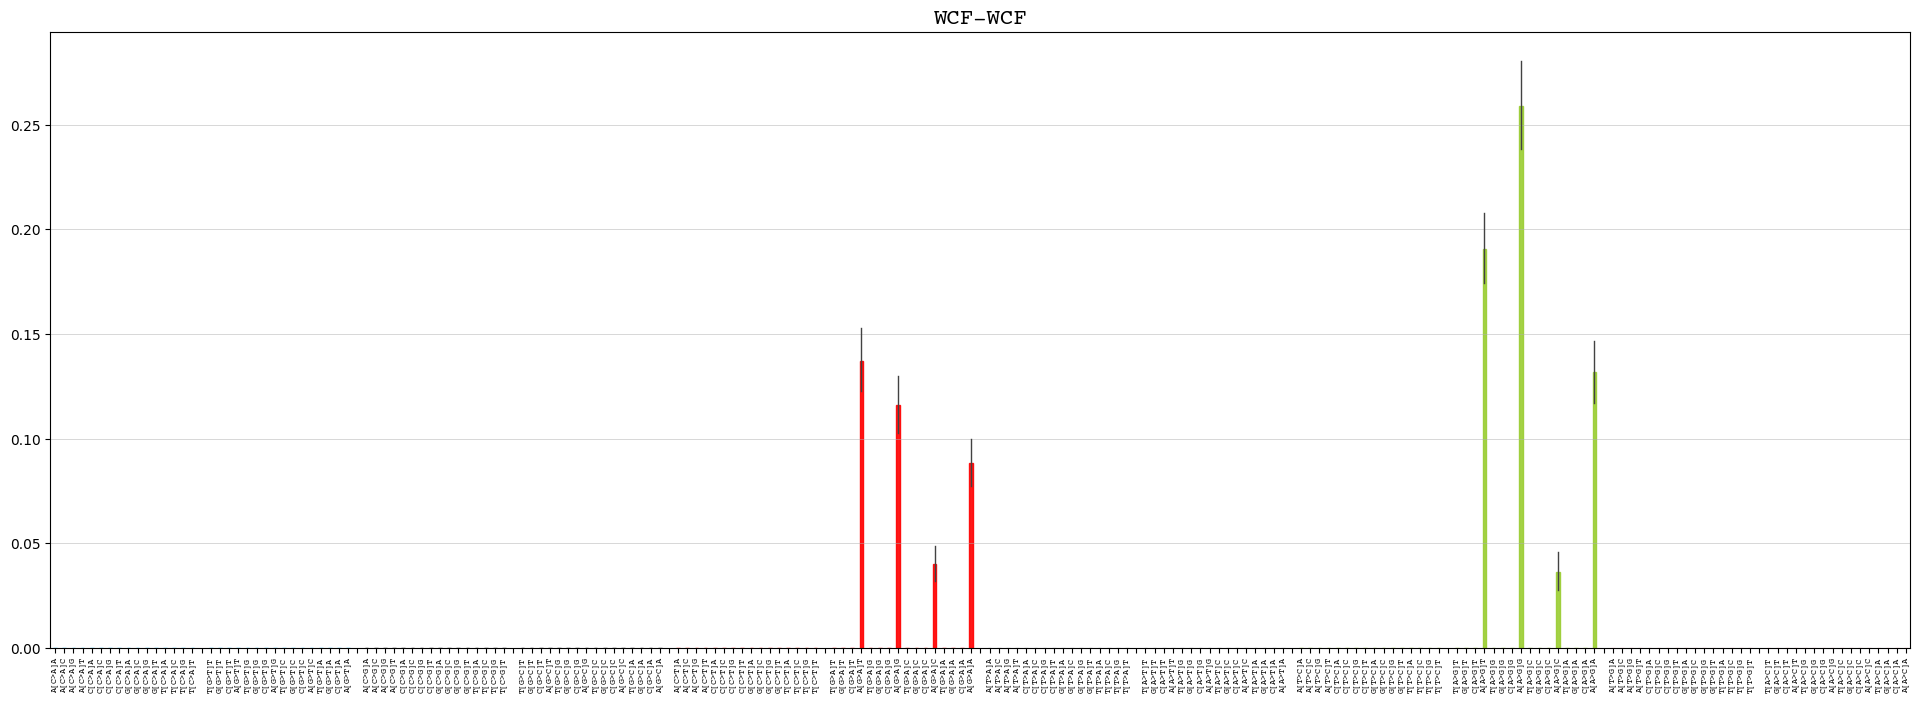

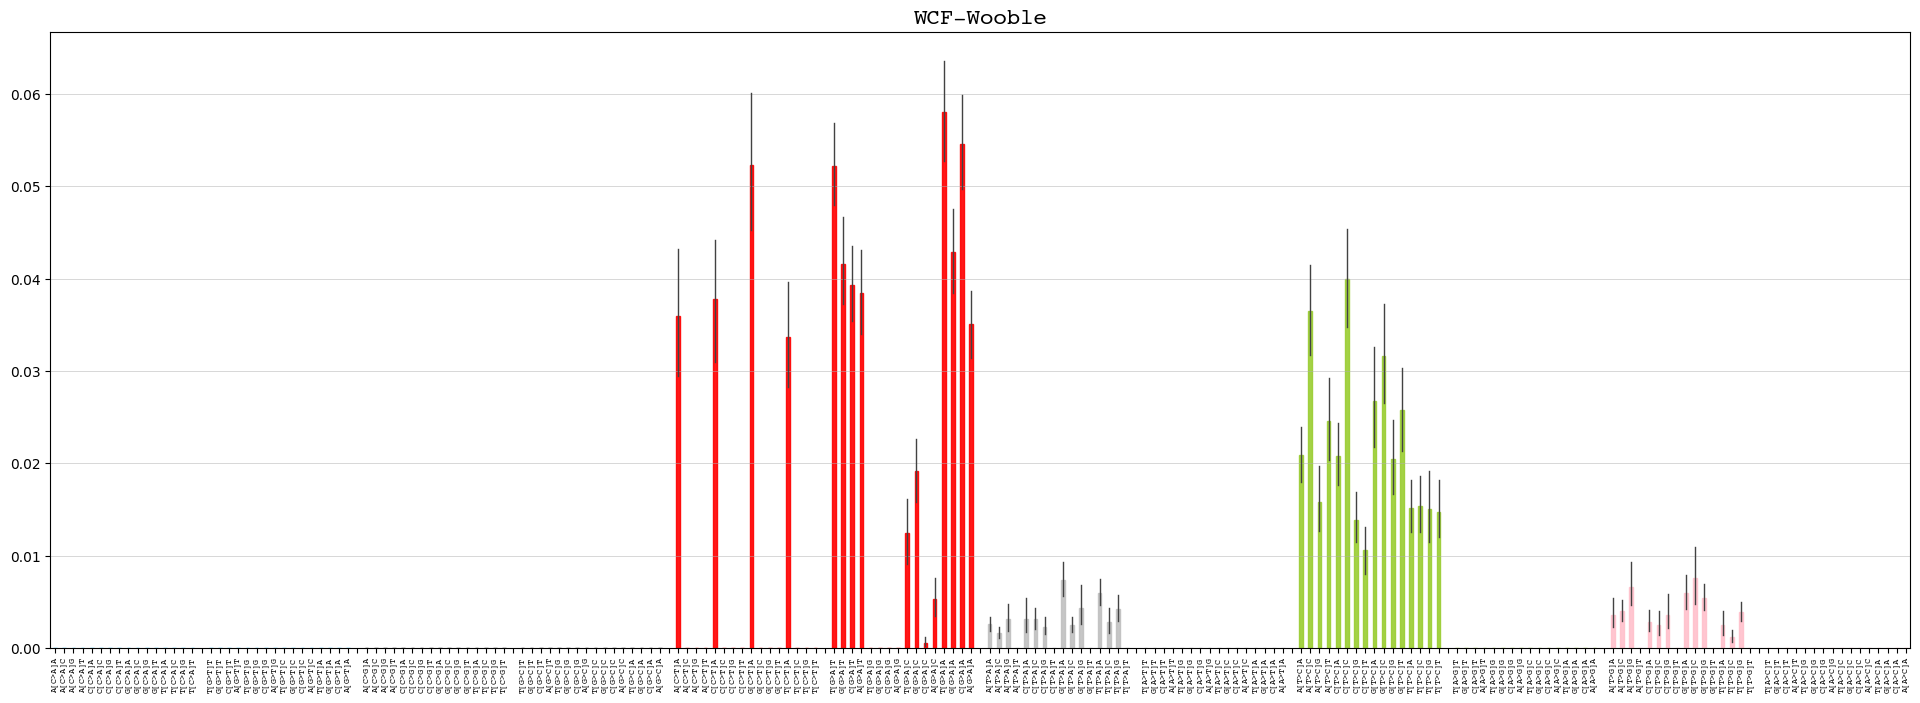

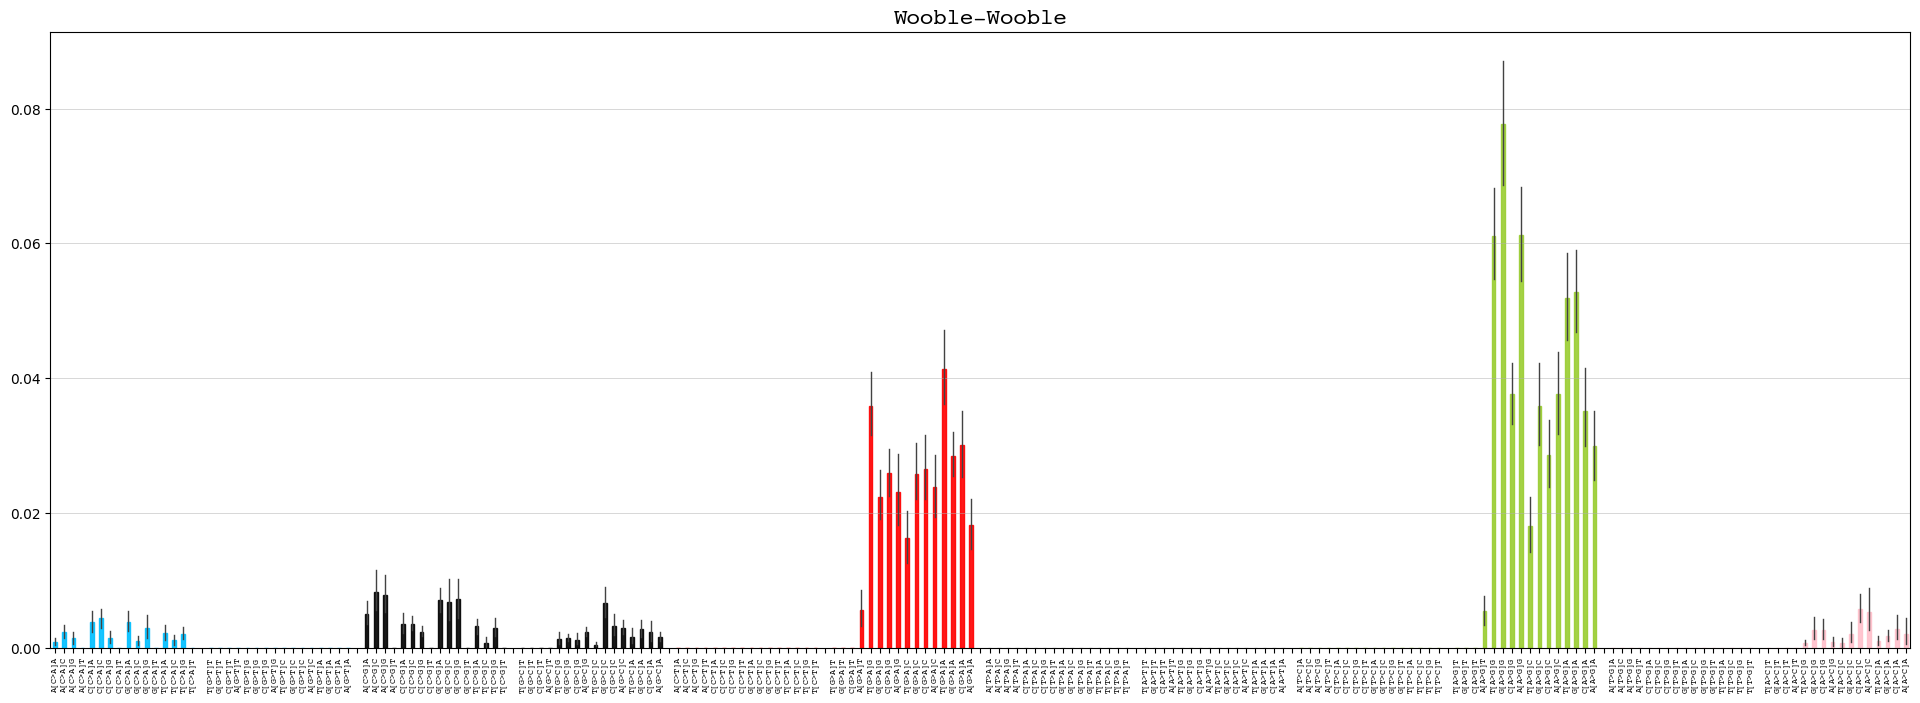

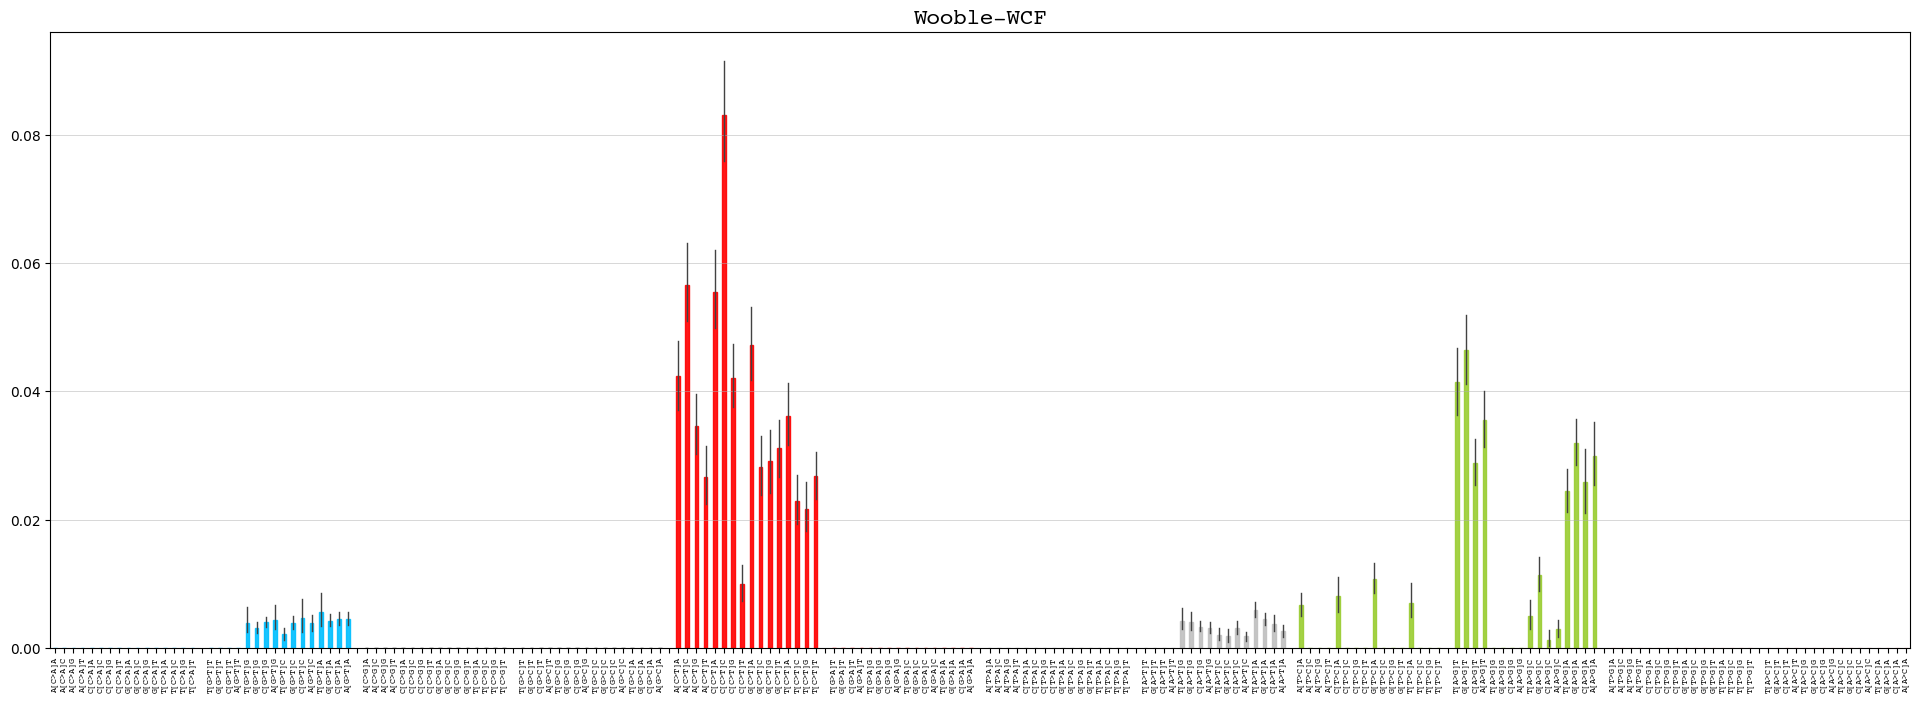

In [27]:
for anti_rel in list_of_anti:
    calculate_mutspec(expected=final_exp, observed=final_obs, type_of_anti_mut=anti_rel)

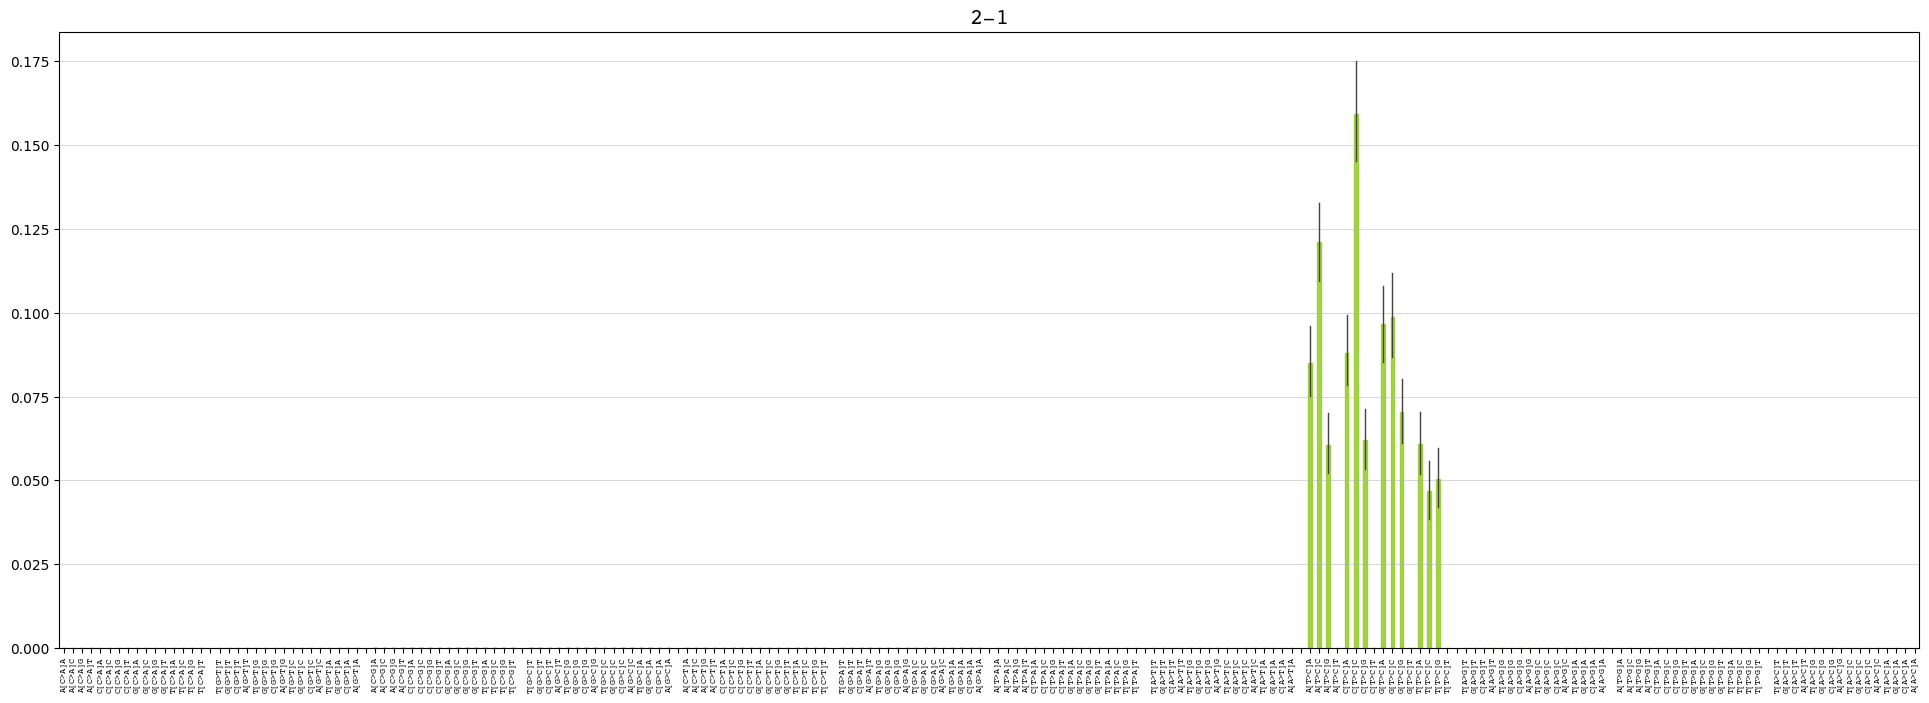

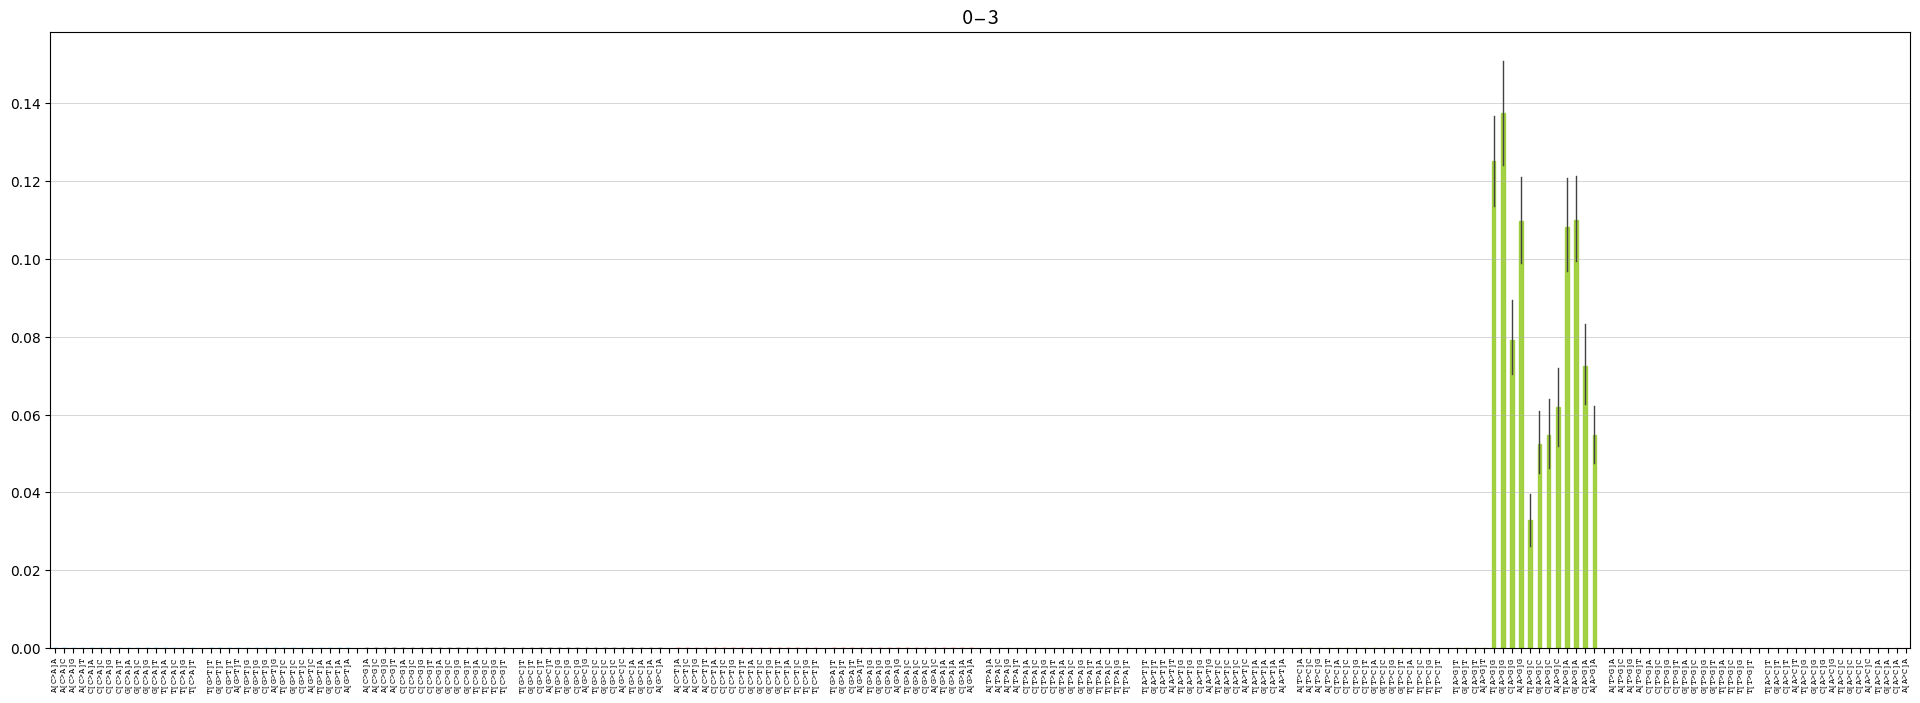

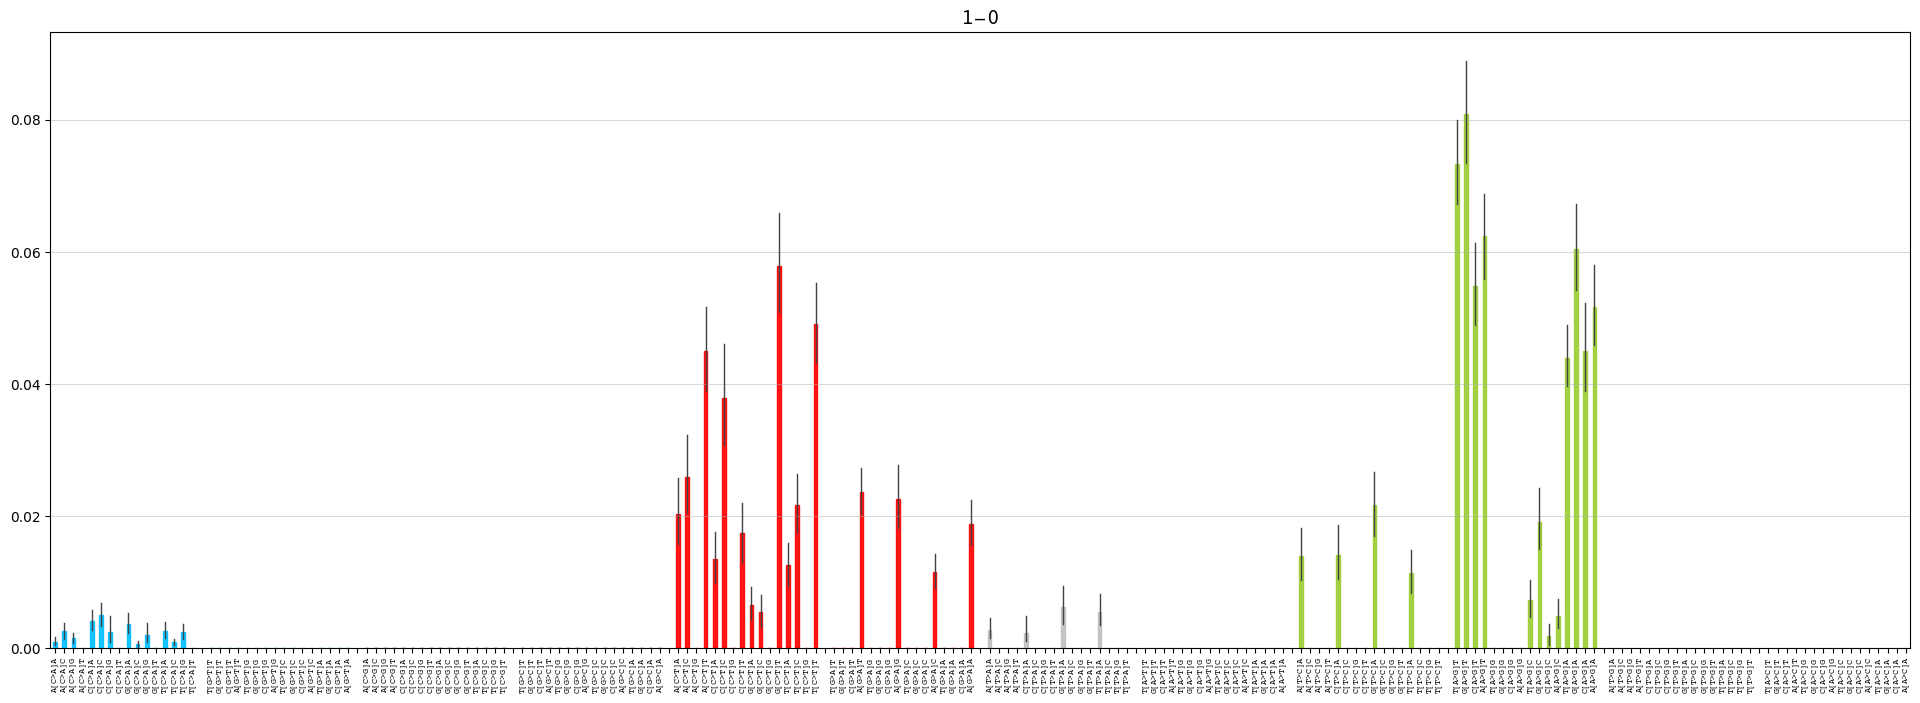

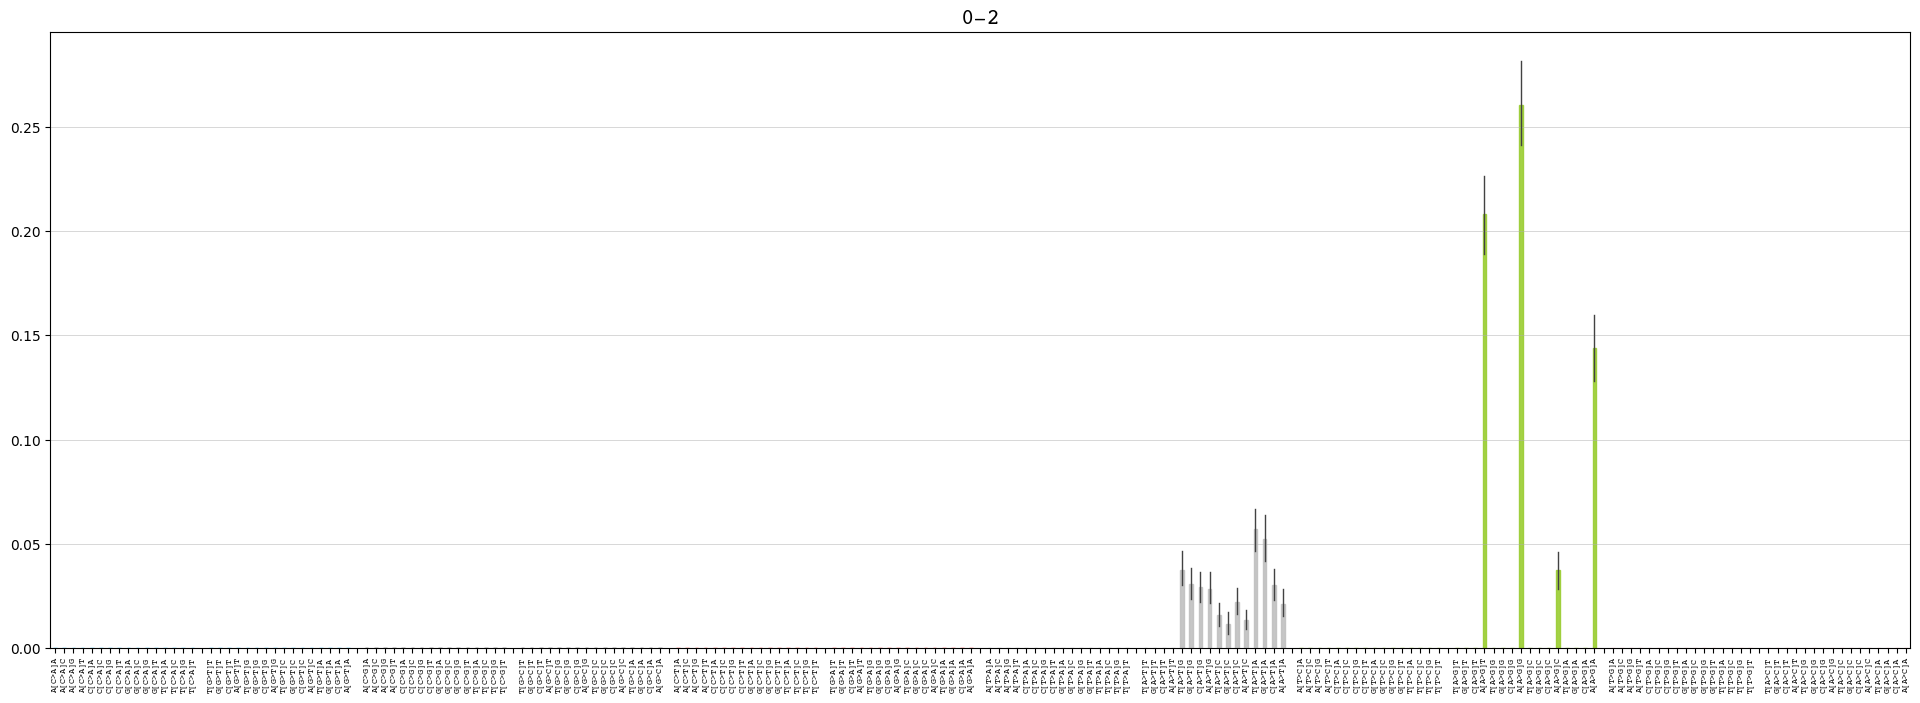

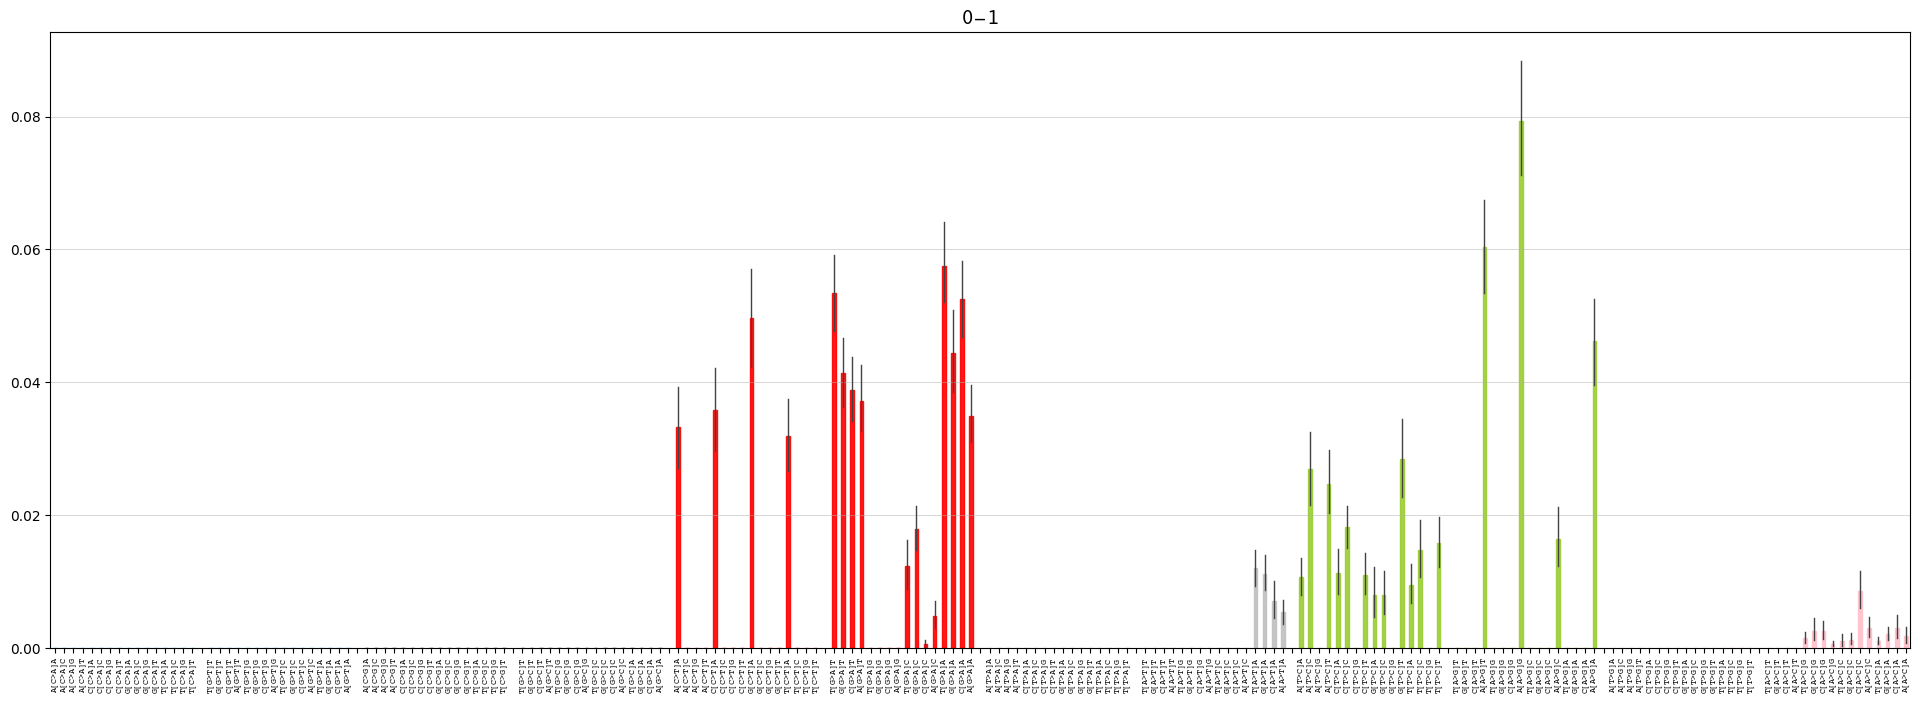

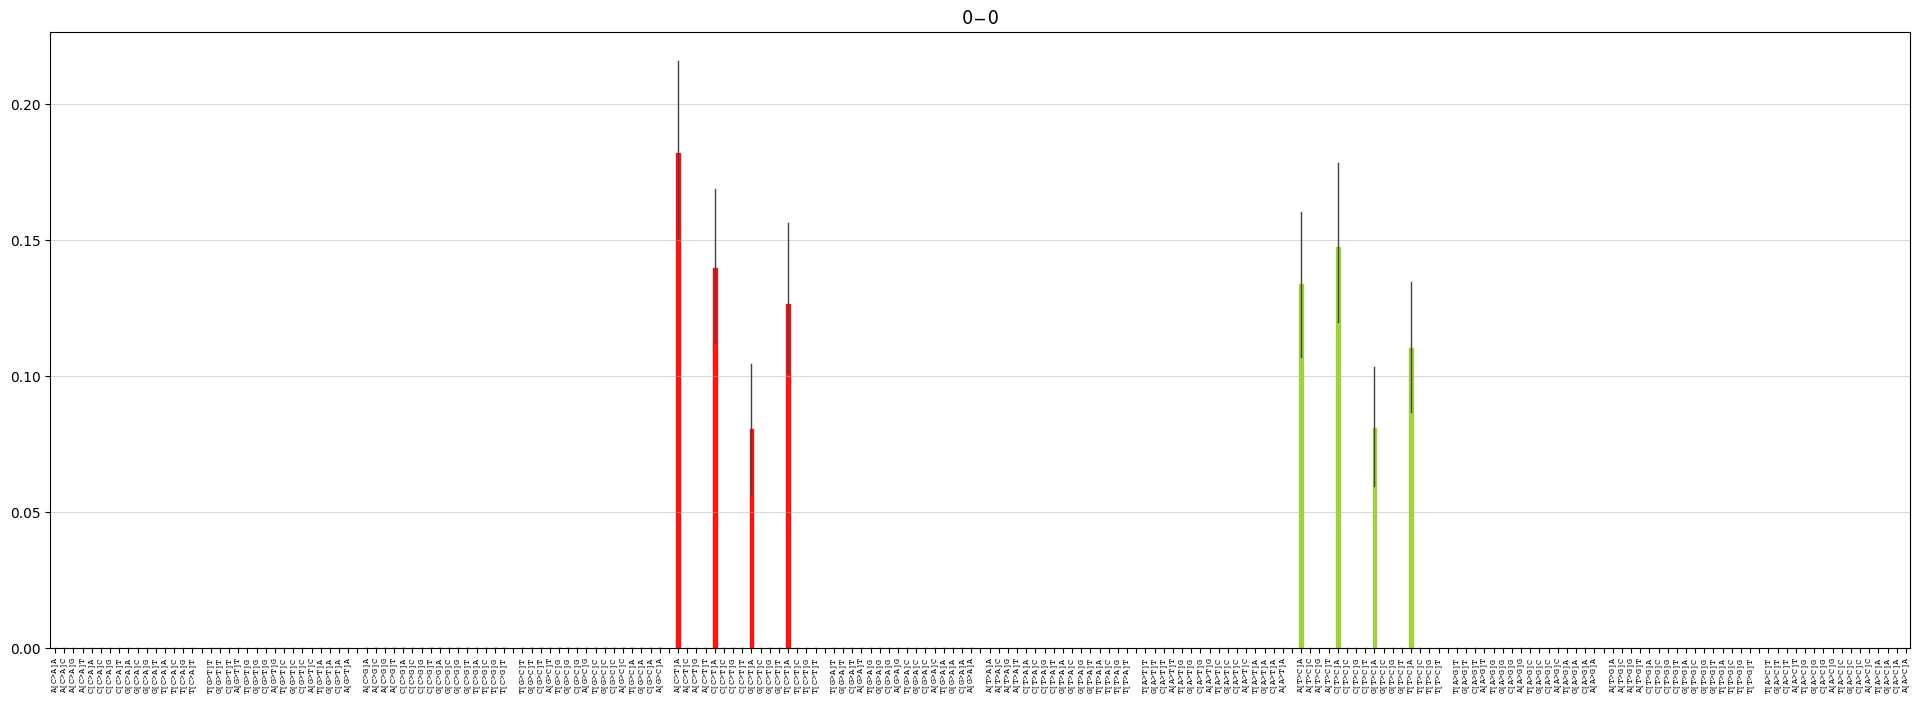

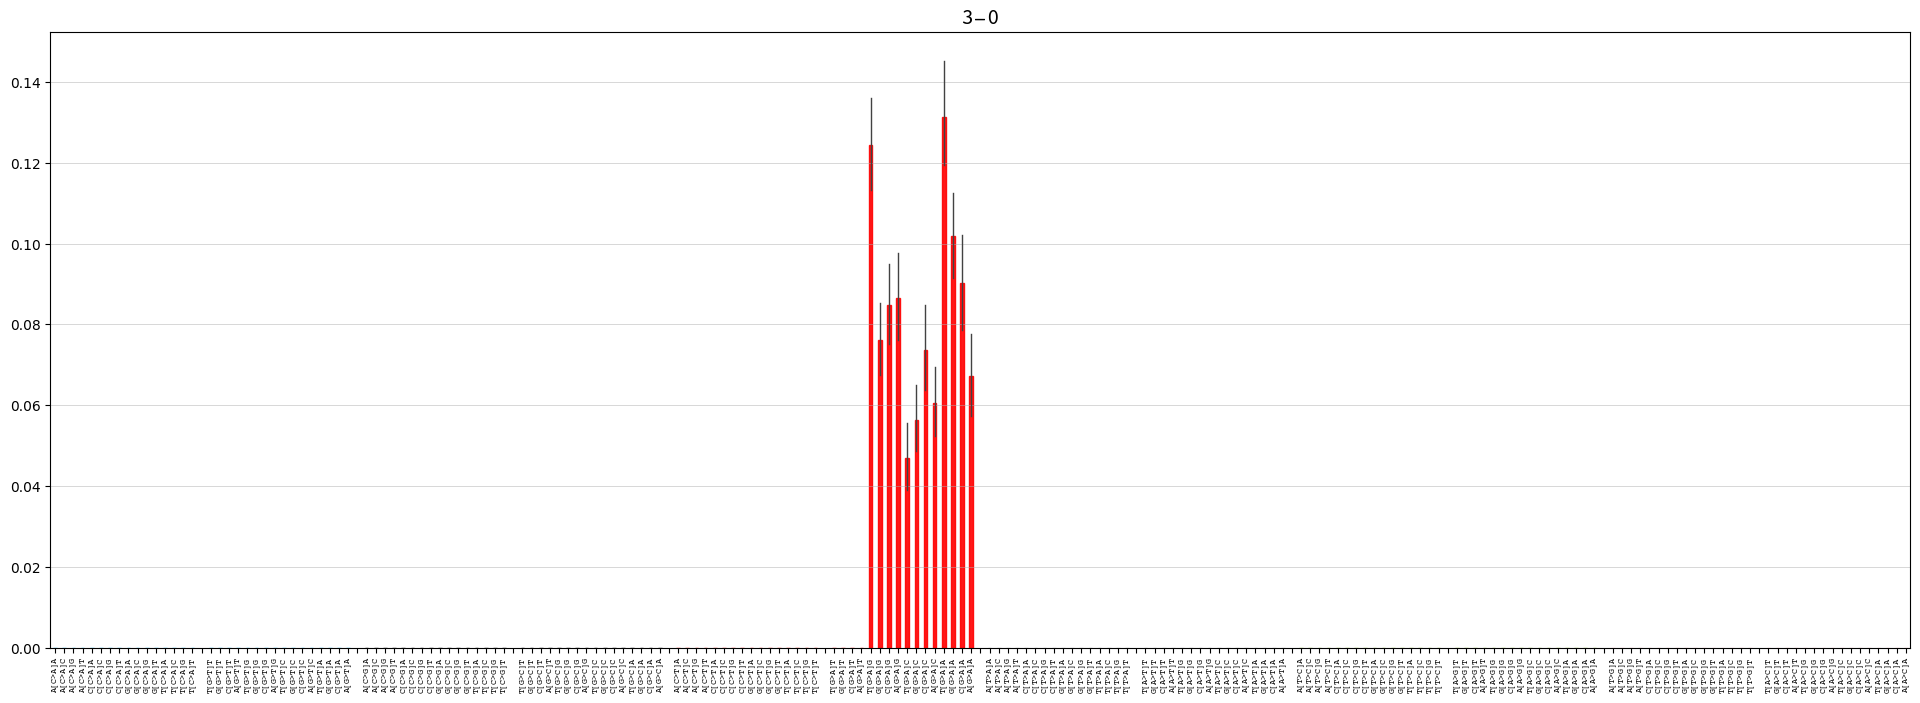

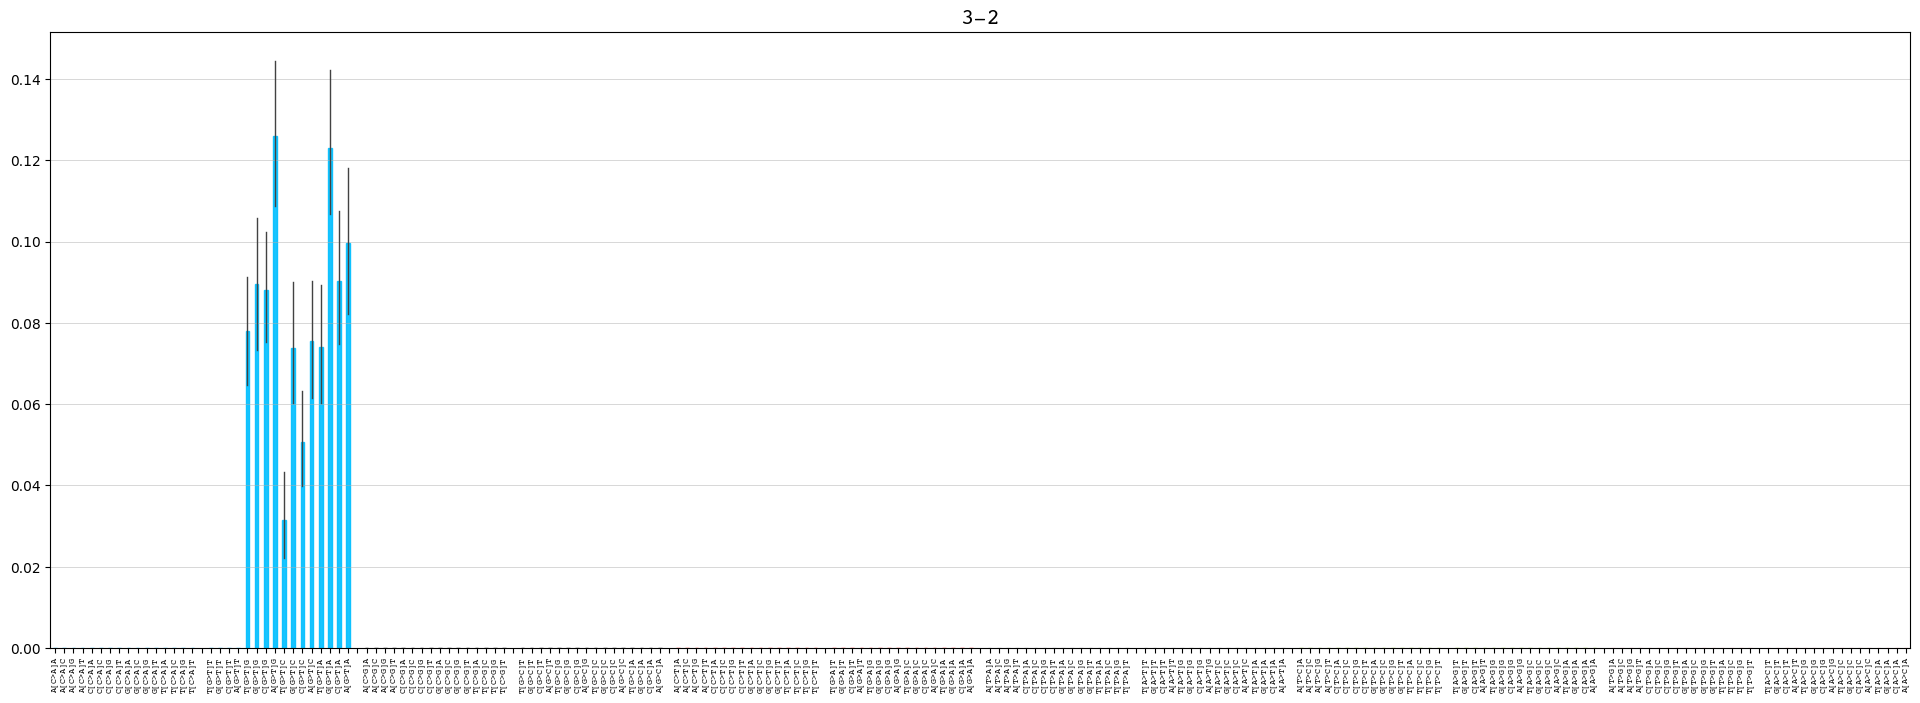

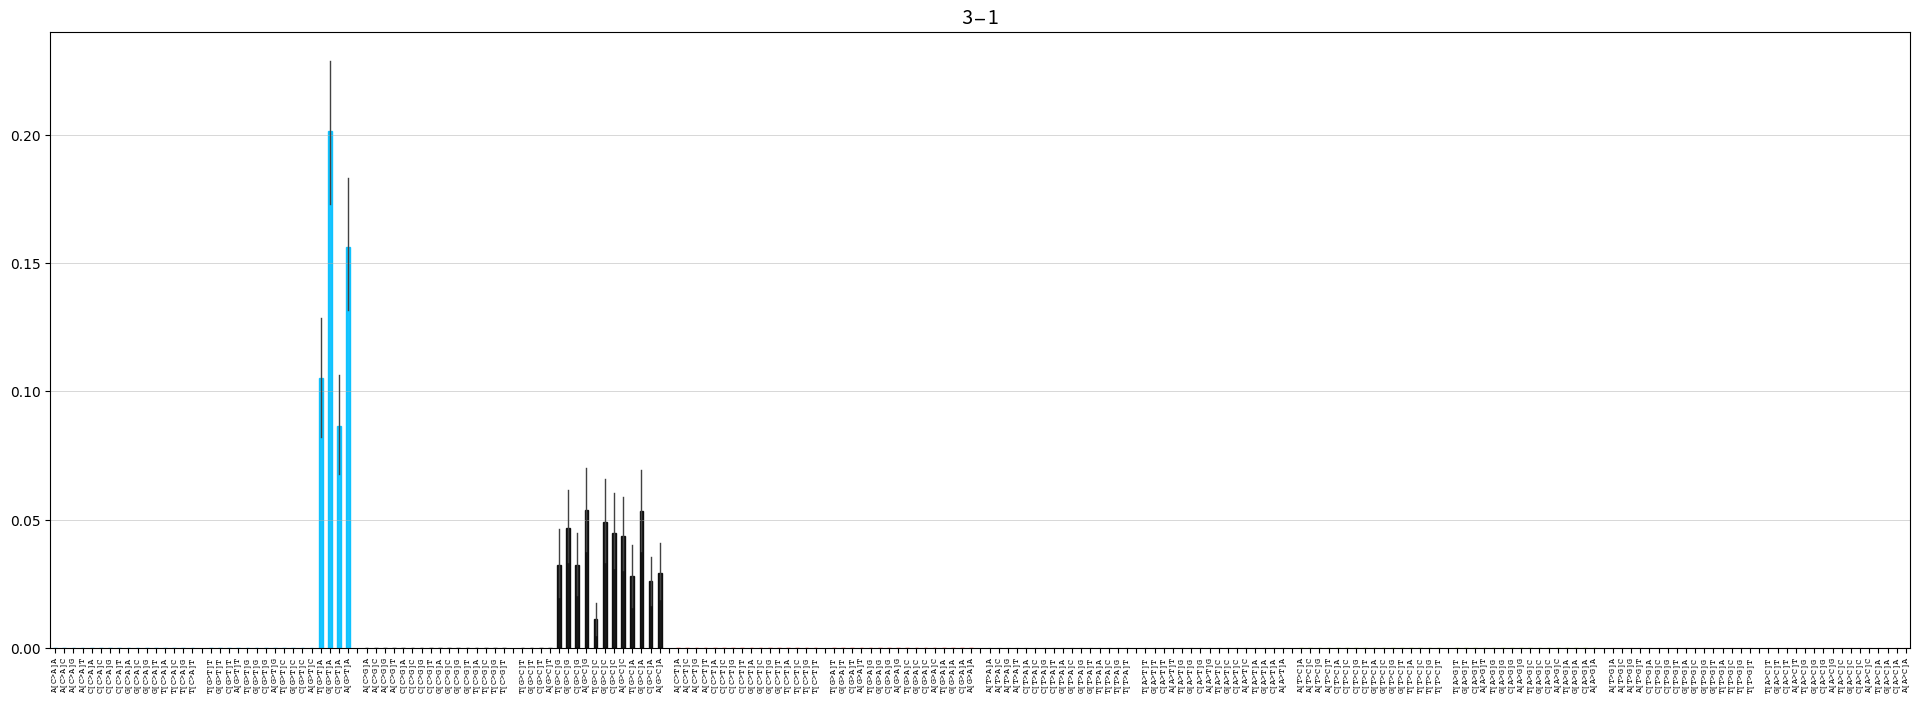

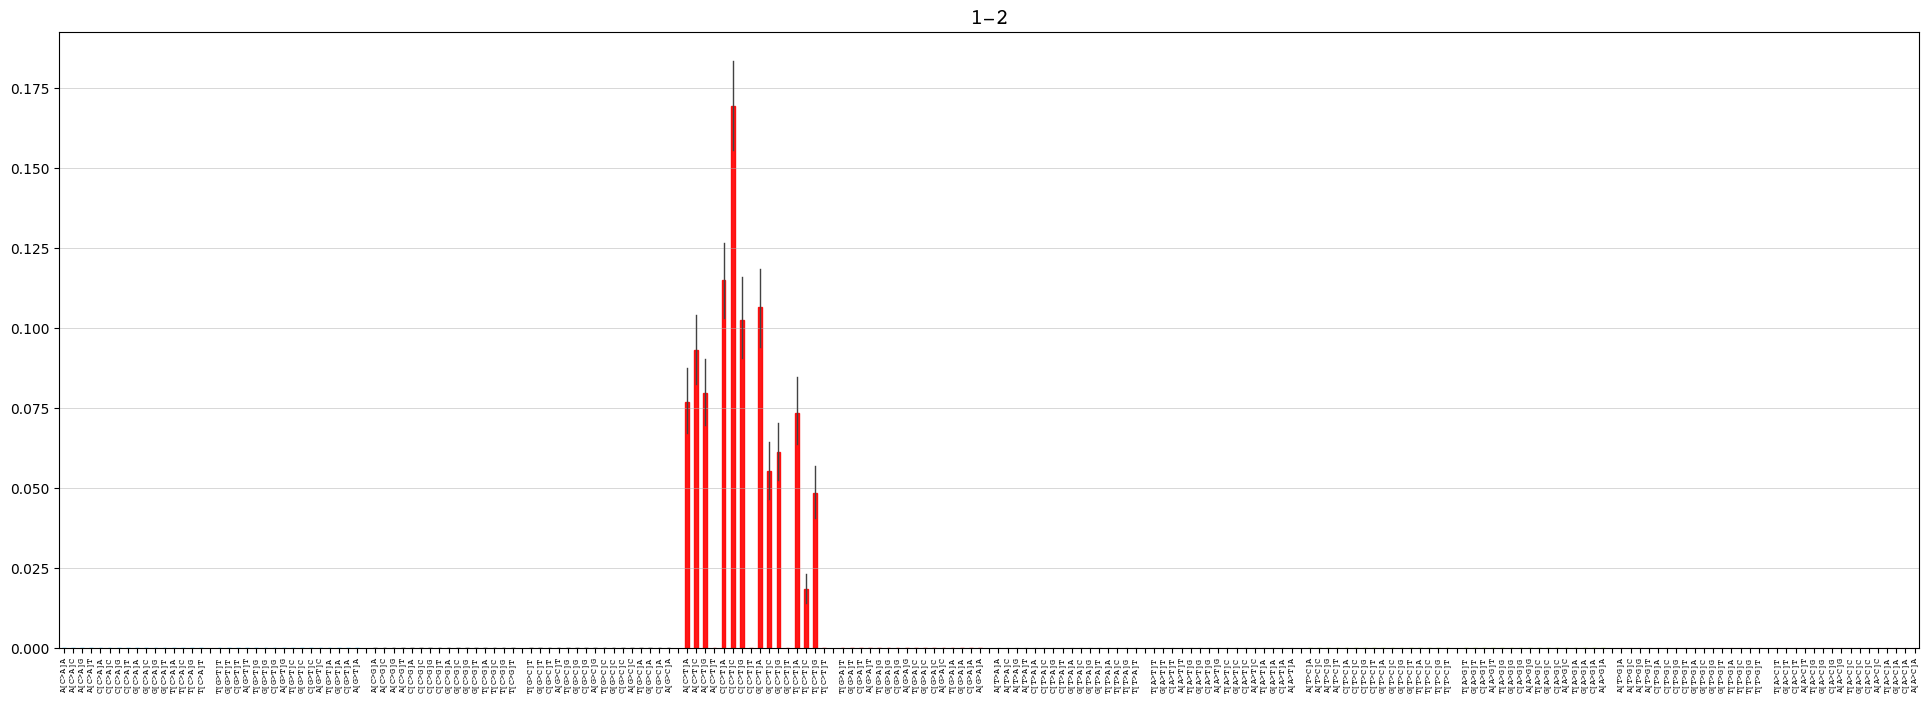

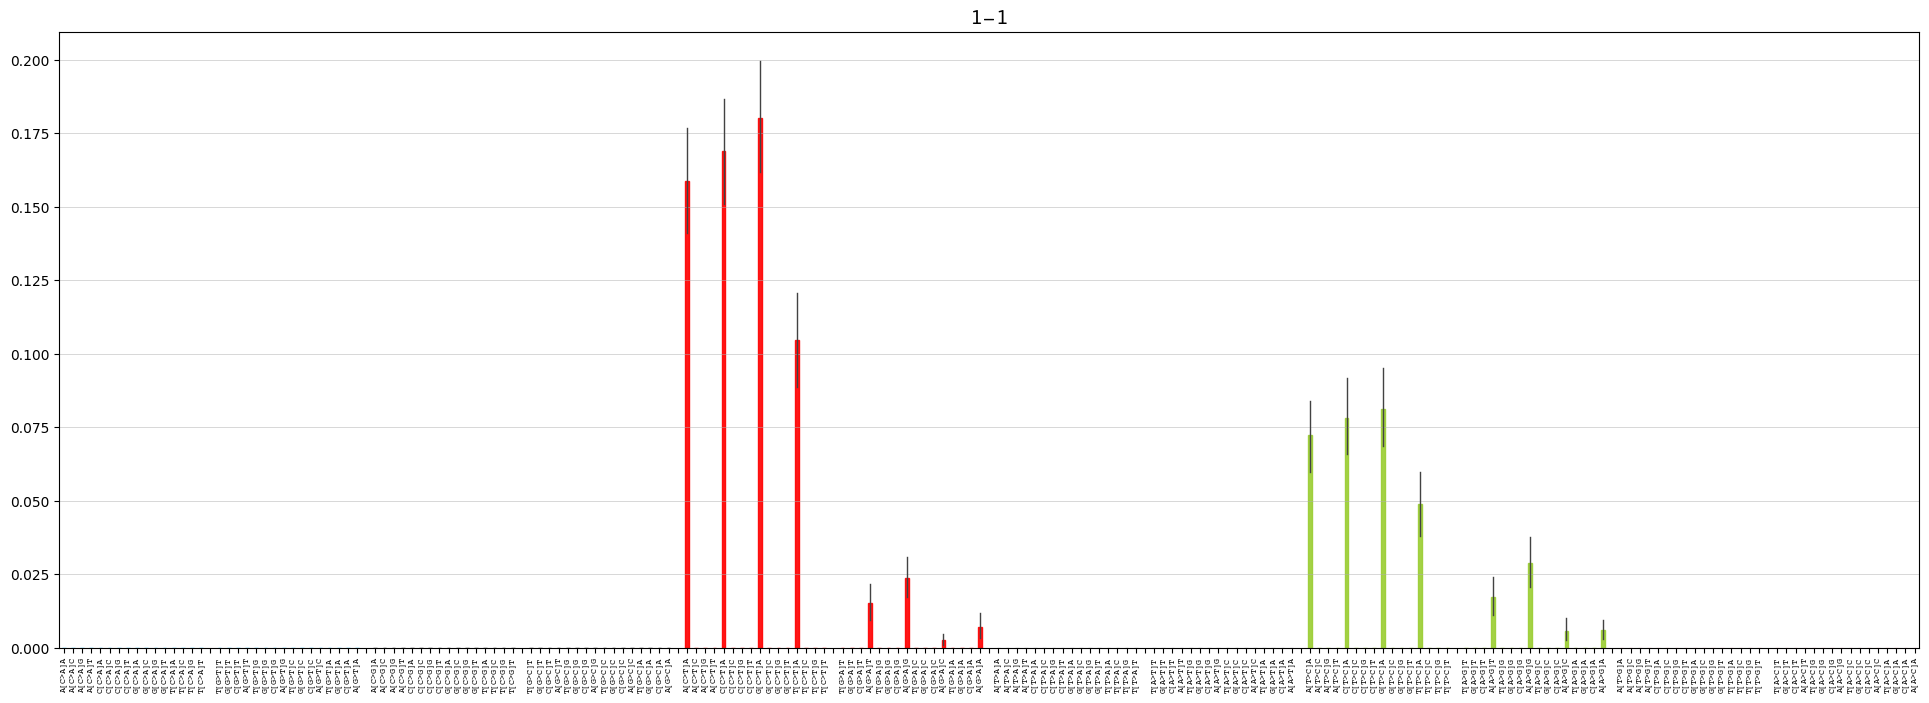

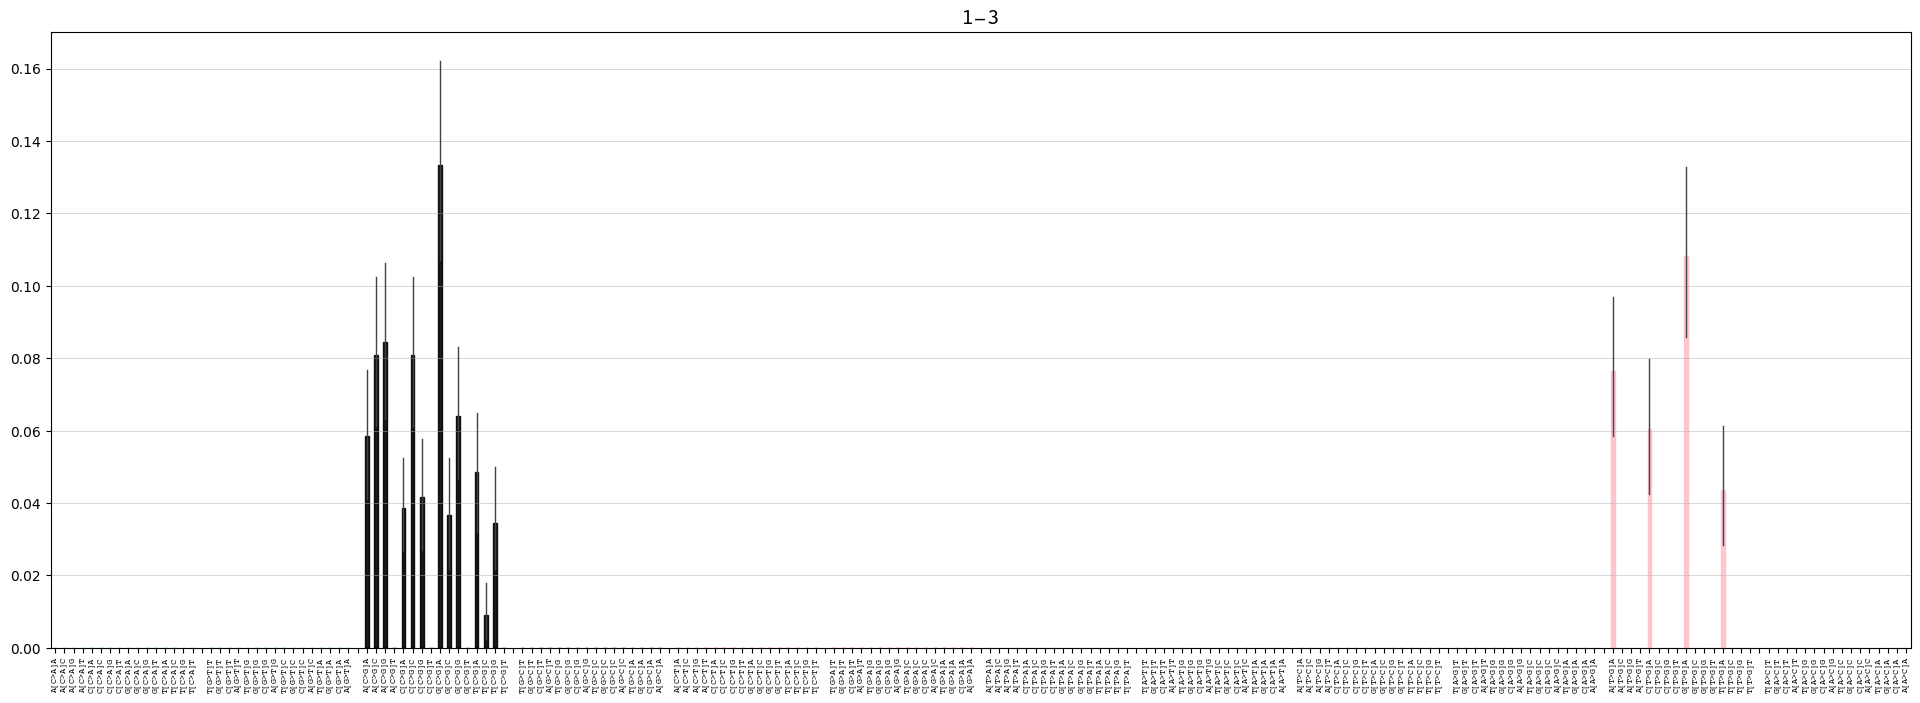

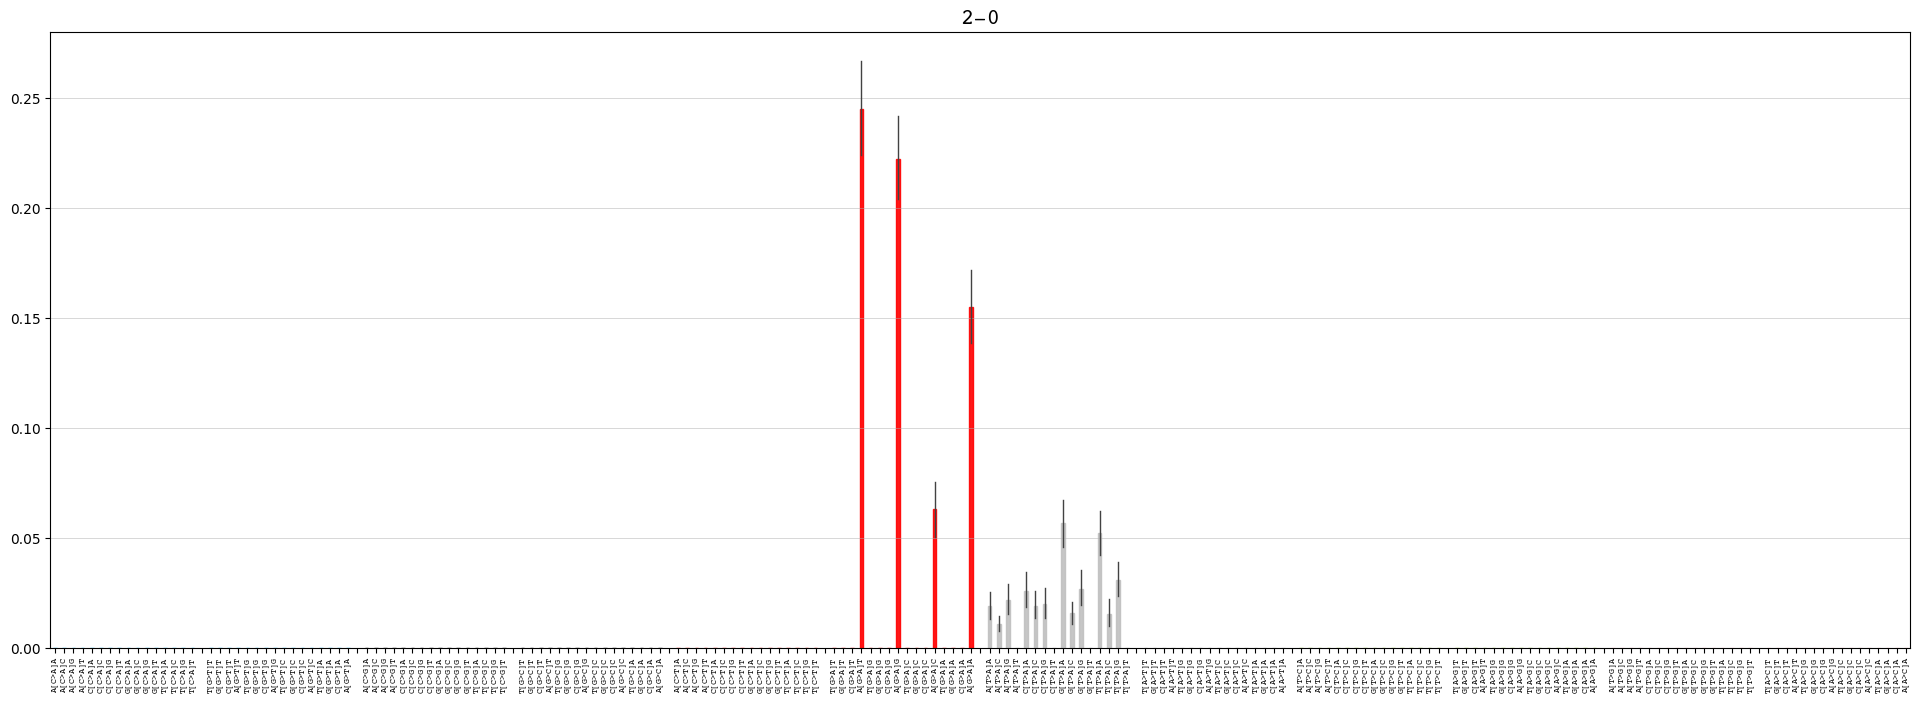

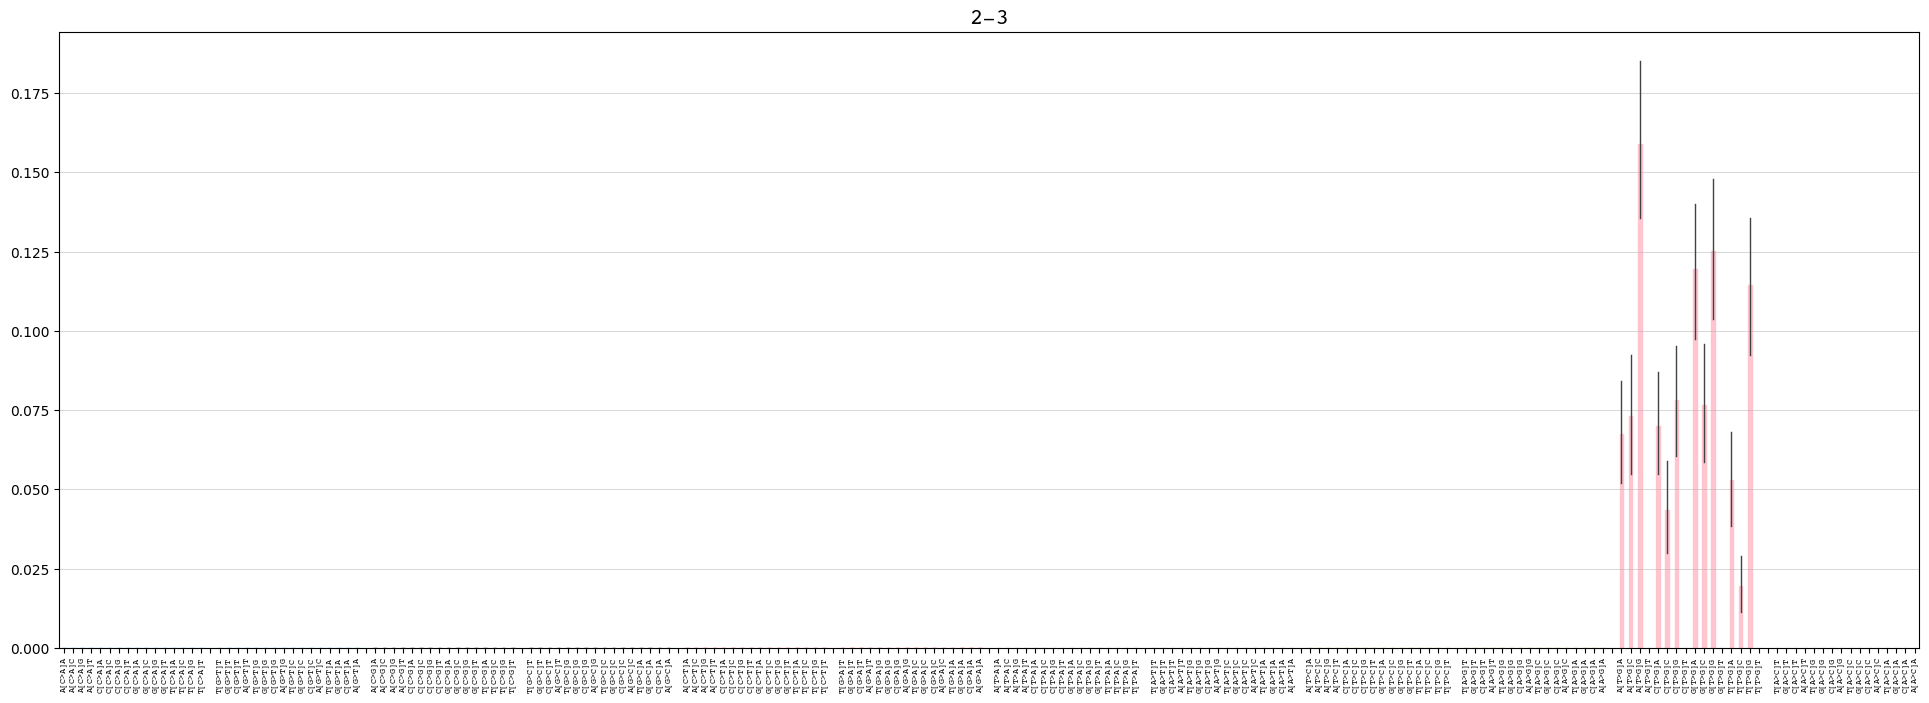

In [28]:
for anti_rel_num in list_of_anti_num:
    calculate_mutspec(expected=final_exp, observed=final_obs, type_of_anti_mut=anti_rel_num, is_it_num=True)

### Save final df

In [29]:
tRNA_anticodon.merge(category_anticodon, on='Codon').to_csv('~/anticodon_relationships.csv', index=False)